In [1]:
# Auto-reload modules on change
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import pandas as pd
from pathlib import Path
from utils.io import read_json, write_json

In [3]:
CLASSES = ["player", "player-jump", "player-land"]
CLS2ID_DICT = {_cls: _id for _id, _cls in enumerate(CLASSES)}
RANDOM_SEED = 42
PREP_DATA_DIR = Path("../data/VNL_500Videos_RTDETR")

In [4]:
RAW_DATA_DIR = Path("../data/VNL_500Videos")

# Scan all tracking infos
tracking_txt_files_list = glob.glob(str(RAW_DATA_DIR / "*.txt"))
print("Found", len(tracking_txt_files_list), "tracking files")

Found 501 tracking files


In [5]:
def process_one_file(input_files):
    # Step 1: read tracking df and add column for object label
    tracking_txt_file, jump_land_json_file = input_files
    tracking_df = pd.read_csv(tracking_txt_file, header=None, names=["frame", "player_id", "x", "y", "w", "h", "score"])

    # Step 2: read jumping json and augment `label` column of tracking df
    jump_land_dict = read_json(jump_land_json_file)
    video = jump_land_dict["video_name"]
    tracking_df["video"] = video

    tracking_df["image_path"] = tracking_df.apply(lambda r: f"{jump_land_dict['video_name']}/{r['frame']:06d}.jpg", axis=1)
    tracking_df["label"] = CLS2ID_DICT["player"]

    jump_land_events_dict = {ev["player_id"]: [je for je in ev["jump_sequences"]] for ev in jump_land_dict["events"]}
    tracking_df.set_index(["video", "frame", "player_id"], inplace=True)

    # Safely set labels only when the (frame, player_id) index exists
    for player_id, jump_sequences in jump_land_events_dict.items():
        pid = int(player_id)
        for event_pair in jump_sequences:
            jump_frame = int(event_pair.get("jumping_frame", -1)) if event_pair.get("jumping_frame") is not None else -1
            land_frame = int(event_pair.get("landing_frame", -1)) if event_pair.get("landing_frame") is not None else -1
            if jump_frame != -1:
                key = (video, jump_frame, pid)
                if key in tracking_df.index:
                    tracking_df.loc[key, "label"] = CLS2ID_DICT["player-jump"]
            if land_frame != -1:
                key = (video, land_frame, pid)
                if key in tracking_df.index:
                    tracking_df.loc[key, "label"] = CLS2ID_DICT["player-land"]
    return tracking_df

# Simple test
process_one_file((tracking_txt_files_list[0], tracking_txt_files_list[0].replace(".txt", ".json")))


x  \
video                                   frame player_id                
pol_usa_men_vnl_2023_1080p_rally_000322 0     1           150.556549   
                                              2           720.098816   
                                              3          1025.312866   
                                              4           888.880371   
                                              5           424.381744   
...                                                              ...   
                                        108   10          650.929138   
                                              11          426.883331   
                                              12          271.438049   
                                              13          670.665344   
                                              14         1742.855469   

                                                                  y  \
video                                   frame player_id               
pol_usa_men_vnl_2023_1080p_rally_000322 0     1          494.209778   
                                              2          546.010742   
                                              3          540.755920   
                                              4          549.180664   
                                              5          668.758850   
...                                                             ...   
                                        108   10         462.676849   
                                              11         619.630554   
                                              12         689.285706   
                                              13         646.010437   
                                              14         772.269958   

                                                                  w  \
video                                   frame player_id               
pol_usa_men_vnl_2023_1080p_rally_000322 0     1           88.357391   
                                              2           78.138794   
                                              3           81.381836   
                                              4           54.201538   
                                              5           77.038666   
...                                                             ...   
                                        108   10          63.574646   
                                              11          79.309784   
                                              12          93.997223   
                                              13         123.474915   
                                              14         135.728760   

                                                                  h     score  \
video                                   frame player_id                         
pol_usa_men_vnl_2023_1080p_rally_000322 0     1          203.757324  1.760141   
                                              2          213.031982  1.748911   
                                              3          204.874146  1.737963   
                                              4          209.726257  1.732948   
                                              5          237.190491  1.714768   
...                                                             ...       ...   
                                        108   10         191.175262  1.749216   
                                              11         162.630615  1.759623   
                                              12          99.453308  1.731399   
                                              13         246.837463  1.762174   
                                              14         274.320496  0.313140   

                                                                                                image_path  \
video                                   frame player_id                                                      
pol_usa_

In [6]:
# Aggregate all videos
import concurrent.futures

all_jobs = [(tracking_txt_file, tracking_txt_file.replace(".txt", ".json")) for tracking_txt_file in tracking_txt_files_list if os.path.isfile(tracking_txt_file.replace(".txt", ".json"))]
with concurrent.futures.ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
    all_dfs_list = executor.map(process_one_file, all_jobs)

master_df = pd.concat(all_dfs_list)

In [7]:
event_df = master_df[master_df.label != 0]
player_only_df = master_df[master_df.label == 0]

print(f"Number of event-ful frames: {len(event_df):,d} ({len(event_df)/len(player_only_df):%})")
print(f"Number of non-event frames: {len(player_only_df):,d}")

Number of event-ful frames: 5,637 (0.379769%)
Number of non-event frames: 1,484,322


In [8]:
# Event frames only account for a small fraction (.38%) -> We need a better ratio for model to not ignore these minor classes, let's say 50:50

num_background_frames = len(event_df)
background_sample_df = player_only_df.sample(num_background_frames, random_state=42)
prep_df_all = pd.concat([event_df, background_sample_df])
print(f"Num Total Samples: {len(prep_df_all):,d}")

Num Total Samples: 11,274


In [9]:
for _cls in CLASSES[1:]:
    print(f"Num {_cls} samples: {len(prep_df_all[prep_df_all.label == CLS2ID_DICT[_cls]]):,d}")

Num player-jump samples: 2,864
Num player-land samples: 2,773


In [10]:
VAL_SPLIT = .2
TEST_SPLIT = .1

In [11]:
all_videos = prep_df_all.index.get_level_values("video").unique().to_series().sample(frac=1, random_state=RANDOM_SEED)
val_videos = all_videos[:int(VAL_SPLIT * len(all_videos))]
test_videos = all_videos[int(VAL_SPLIT * len(all_videos)):int((TEST_SPLIT + VAL_SPLIT) * len(all_videos))]

print(f"{len(all_videos)=}, {len(val_videos)=}, {len(test_videos)=}, ")

len(all_videos)=500, len(val_videos)=100, len(test_videos)=50, 


In [12]:
prep_df_all["split"] = "train"

# set val split
prep_df_all.loc[val_videos, "split"] = "valid"
prep_df_all.loc[test_videos, "split"] = "test"

for split in ["train", "valid", "test"]:
    print(f"Num {split} samples: {len(prep_df_all[prep_df_all.split == split]):,d}")

Num train samples: 7,894
Num valid samples: 2,250
Num test samples: 1,130


In [13]:
import cv2

# assume all frames have the same dim, now get image resolution for coor normalisation
image_path = prep_df_all.sample(1)["image_path"].iloc[0]
FRAME_HEIGHT, FRAME_WIDTH, _ = cv2.imread(RAW_DATA_DIR / image_path).shape
print(f"{FRAME_WIDTH=}, {FRAME_HEIGHT=}")

FRAME_WIDTH=1920, FRAME_HEIGHT=1080


In [14]:
# create dirs for new dataset
import shutil

shutil.rmtree(PREP_DATA_DIR)
for dir in "train valid test".split():
    os.makedirs(PREP_DATA_DIR / dir, exist_ok=True)

def link_image(row_iter: tuple[int, pd.Series]):
    _, row = row_iter
    image_path = PREP_DATA_DIR / row.split / row.image_path.replace("/", "_")

    # Link file
    image_path.unlink(missing_ok=True)
    os.symlink(os.path.abspath(RAW_DATA_DIR / row.image_path), image_path)


# test one row
link_image(next(iter(prep_df_all.iterrows())))

In [15]:
# Link all frames concurrently

with concurrent.futures.ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
    executor.map(link_image, prep_df_all.iterrows())

In [16]:
for split in "train valid test".split():
    label_path = PREP_DATA_DIR / split / "_annotations.coco.json"
    split_dict = prep_df_all[prep_df_all.split == split].to_dict(orient="dict")

    images = {path[:-4]: {"id": idx, "file_name": path.replace("/", "_"), "height": FRAME_HEIGHT, "width": FRAME_WIDTH} for idx, path in enumerate(set(split_dict["image_path"].values()))}

    annotations = []

    for idx, (key, value) in enumerate(split_dict["x"].items()):
        image_key = f"{key[0]}/{key[1]:06d}"
        image_id = images[image_key]["id"]
        bbox = list(map(lambda k: int(split_dict[k][key]), "x y w h".split()))
        area = bbox[-2] * bbox[-1]
        annotations.append(dict(
            id=idx, image_id=image_id, bbox=bbox, category_id=split_dict["label"][key], area=area, segmentation=[], iscrowd=0
        ))
    

    label_data = dict(
        categories=[{"id": _id, "name": _cls, "supercategory": "people"} for _cls, _id in CLS2ID_DICT.items()],
        images=list(images.values()),
        annotations=annotations
    )  
    write_json(label_path, label_data)

Done, its time for TRAINING

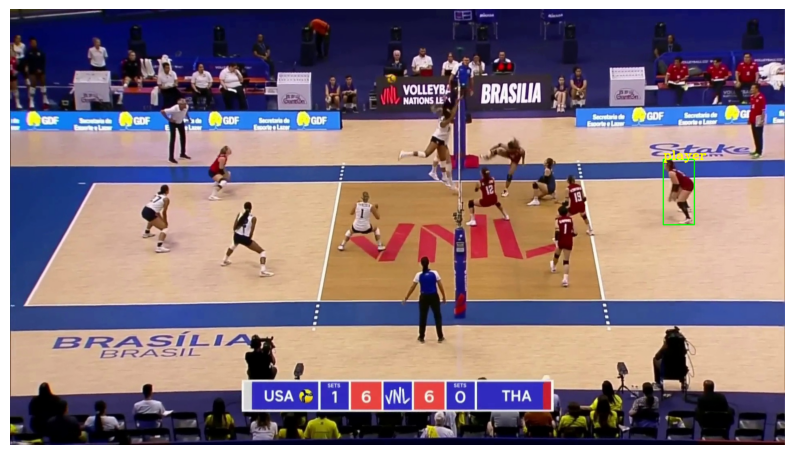

In [17]:
# Visualize new annotations for integrity
import cv2
import matplotlib.pyplot as plt
import random

annotations = read_json("../data/VNL_500Videos_RTDETR/test/_annotations.coco.json")

# pick a random annotation
sample = random.choice(annotations["annotations"])
image_path = (
    PREP_DATA_DIR / "test" / annotations["images"][sample["image_id"]]["file_name"]
)


im = cv2.imread(image_path)
x, y, w, h = sample["bbox"]
im = cv2.rectangle(im, (x, y), (x + w, y + h), color=(0, 255, 0), thickness=2)
im = cv2.putText(
    im,
    CLASSES[sample["category_id"]],
    (x, y),
    fontFace=cv2.FONT_HERSHEY_COMPLEX,
    fontScale=1,
    color=(0, 255, 255),
    thickness=2,
)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(im)
plt.axis("off")
plt.show()